In [1]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.date, event_log.actor_id,
        user.username, event_log.event_id, event.name
        from event_log
        join event on event.id = event_log.event_id
        join user on user.id = event_log.actor_id
        order by event_log.id
    """, db)
    df.set_index("id", inplace=True)
    
    return delete_consecutive_events(df)

def delete_consecutive_events(df):
    df.sort_values(["actor_id", "date"], inplace=True)
    df["time_diff_seconds"] = df["date"].diff().map(lambda x: x.total_seconds())
    
    to_delete = (df["time_diff_seconds"] >= 0) & (df["time_diff_seconds"] < 3)
    df.drop(df[to_delete].index, inplace=True)
    
    return df

event_log = read_event_log()
event_log.tail(100)

/home/kulla/.local/share/asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,date,actor_id,username,event_id,name,time_diff_seconds
id,,,,,,
378277,2021-03-09 08:01:34,197401,Annika-Hemlein,5,entity/revision/add,8.0
378278,2021-03-09 08:01:41,197401,Annika-Hemlein,5,entity/revision/add,7.0
378281,2021-03-09 08:44:48,197401,Annika-Hemlein,5,entity/revision/add,2587.0
378287,2021-03-09 08:44:52,197401,Annika-Hemlein,5,entity/revision/add,4.0
378291,2021-03-09 08:45:00,197401,Annika-Hemlein,5,entity/revision/add,8.0
...,...,...,...,...,...,...
379200,2021-03-10 16:04:17,198070,Ryker,9,discussion/comment/create,-58325.0
379212,2021-03-10 20:34:46,198102,Vater,8,discussion/create,16229.0
379231,2021-03-11 08:11:54,198102,Vater,9,discussion/comment/create,41828.0


In [167]:
def compute_edits_per_day_per_user(df, event_ids=[5,6]):
    current_date = df["date"].max()
    df = df[df["date"] > current_date - pd.Timedelta(days=365.25*4)]
    df = df[df["event_id"].isin(event_ids)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

edits_per_day_per_user = compute_edits_per_day_per_user(event_log)
edits_per_day_per_user

,arekkas,Deleted,Simon,HokkaidokÃƒÂ¼rbis,Sophia,Renate,Laura,Hannes,Tinsaye,pinkmuffin,...,Wo_Fo,Anton_Zikmund,Mathes,Katrin_K,Matheo,KerstinPecher,reallpk,Rami,Gianluca,Annika-Hemlein
date,,,,,,,,,,,,,,,,,,,,,
2017-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-15,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
2021-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,9.0,13.0,0.0,0.0,14.0,1.0,34.0
2021-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,25.0,0.0,0.0,17.0,6.0,65.0


```
+----+-----------------------------+-------------+
| id | name                        | description |
+----+-----------------------------+-------------+
|  1 | taxonomy/term/associate     | NULL        |
|  2 | taxonomy/term/create        | NULL        |
|  3 | license/object/set          | NULL        |
|  4 | entity/create               | NULL        |
|  5 | entity/revision/add         | NULL        |
|  6 | entity/revision/checkout    | NULL        |
|  7 | entity/link/create          | NULL        |
|  8 | discussion/create           | NULL        |
|  9 | discussion/comment/create   | NULL        |
| 10 | uuid/trash                  | NULL        |
| 11 | entity/revision/reject      | NULL        |
| 12 | taxonomy/term/update        | NULL        |
| 13 | uuid/restore                | NULL        |
| 14 | discussion/comment/archive  | NULL        |
| 15 | taxonomy/term/parent/change | NULL        |
| 16 | discussion/restore          | NULL        |
| 17 | taxonomy/term/dissociate    | NULL        |
| 18 | entity/link/remove          | NULL        |
+----+-----------------------------+-------------+
```

In [224]:
event_types = {
    "Inhalt": [5,6],
    "Kommentare": [8,9,14,16],
    "Reviewing": [6,11],
    "Taxonomy": [1,2,12,15,17],
    "Administration": [10,13,3]
}
event_types["Inhalt + Taxonomy"] = list(event_types["Inhalt"] + event_types["Taxonomy"])

df_cache = dict()

for event_type, event_ids in event_types.items():
    df_cache[event_type] = compute_edits_per_day_per_user(event_log, event_ids)

In [160]:
community = pd.read_csv("community.csv")
community.set_index("username", inplace=True)

def is_not_team(username):
    return username not in community.index or community.loc[username]["team_or_ex-team"] != 1

display(is_not_team("kathongi"))
display(is_not_team("chdieter"))
display(is_not_team("kurrater"))
display(is_not_team("arekkas"))

False

True

True

True

In [185]:
%load_ext Cython

In [216]:
%%cython
cimport numpy as np

cpdef is_long(x):
    return 1 if x[0] and x[1] and x[int(len(x)/2)] else 0

In [255]:
import matplotlib.pyplot as plt

from ipywidgets import interact, interact_manual

def show_author_count_plot(lower="10", event_type="Inhalt", with_team=True, time_interval="90",
                           long_time=False, compare=False, lower_b=None, event_type_b=None,
                           with_team_b=None, long_time_b=None, time_interval_b=None):
    #display(Markdown(f"# Auswertung Anzahl Autor:innen (#Events >= {lower}; {event_type})"))
    #display(Markdown("Wenn Events in der Vergangenheit in der Summer größer sind"))
    
    if lower_b == None:
        lower_b = lower
    if event_type_b== None:
        event_type_b = event_type
    if with_team_b== None:
        with_team_b = with_team
    if long_time_b==None:
        long_time_b = long_time
    if time_interval_b == None:
        time_interval_b = time_interval
    
    def compute(lower, event_type, with_team, time_interval, long_time):
        lower = int(lower)
        time_interval = int(time_interval)

        df = df_cache[event_type]

        if not with_team:
            df = df[[c for c in df.columns if is_not_team(c)]]

        df = df.rolling(time_interval, min_periods=time_interval).sum()
        df.dropna(inplace=True)
        df = df.astype("float")
        df.where(df >= lower, False, inplace=True)
        df.where(df < lower, True, inplace=True)

        if long_time:
            #def is_long(x):
            #    return x[0] and x[1] and x[time_interval]

            df = df.rolling(2*time_interval+1, min_periods=2*time_interval+1).aggregate(is_long)
            df.dropna(inplace=True)

        return df.apply(lambda d: d.sum(), axis=1)
    
    df = pd.DataFrame({
        "a": compute(lower, event_type, with_team, time_interval, long_time) 
    })
    
    if compare:
        df["b"] = compute(lower_b, event_type_b, with_team_b, time_interval_b, long_time_b)
    
    display(Markdown("### Plot"))
    df.plot(figsize=(20,10), ylim=(0, df.max().max()*1.1))
    plt.show()
    
    def show_data(d):
        idmax = d.idxmax()
        current = d[-1]
        one_year_before = d[-365]
        display(Markdown(f"Current: {current}"))
        display(Markdown(f"One year before: {one_year_before}"))
        display(Markdown(f"Day of maximum: {idmax}"))
    
    display(Markdown("## Data a"))
    show_data(df["a"])
    
    if compare:
        display(Markdown("## Data b"))
        show_data(df["b"])
    
    display(df.describe())


interact_manual(show_author_count_plot, event_type=event_types.keys(),
                lower="10", time_interval="90",
                with_team=True, long_time=False, compare=False,
                event_type_b=event_types.keys(),
                lower_b="10", time_interval_b="90",
                with_team_b=True, long_time_b=False)

interactive(children=(Text(value='10', description='lower'), Dropdown(description='event_type', options=('Inha…

<function __main__.show_author_count_plot(lower='10', event_type='Inhalt', with_team=True, time_interval='90', long_time=False, compare=False, lower_b=None, event_type_b=None, with_team_b=None, long_time_b=None, time_interval_b=None)>

# Anzahl aktiver Autor:innen stabil über die Jahre, im letzten Jahr leicht steigend

### Plot

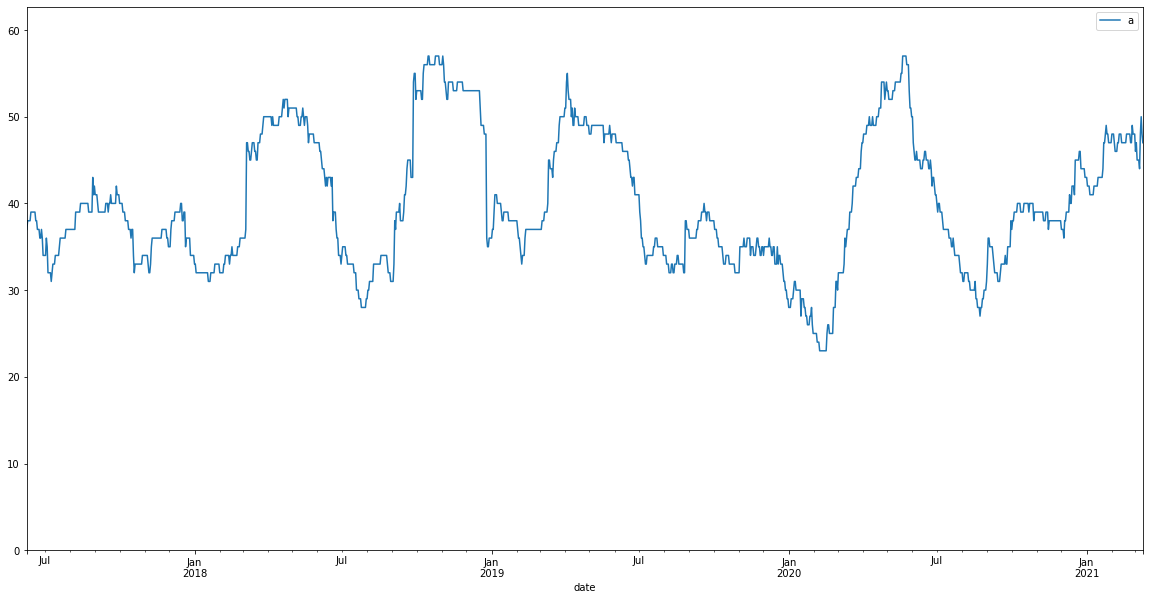

## Data

Current: 47

One year before: 36

Day of maximum: 2018-10-15 00:00:00

,a
count,1372.000000
mean,40.005102
std,7.654986
min,23.000000
25%,34.000000
50%,38.000000
75%,47.000000
max,57.000000


In [234]:
display(Markdown("# Anzahl aktiver Autor:innen stabil über die Jahre, im letzten Jahr leicht steigend"))
show_author_count_plot()

# with_team hat kaum einen Einfluss auf den Verlauf -> nicht alle Teammitglieder sind dabei + ohne Team <= Hälfte ca

### Plot

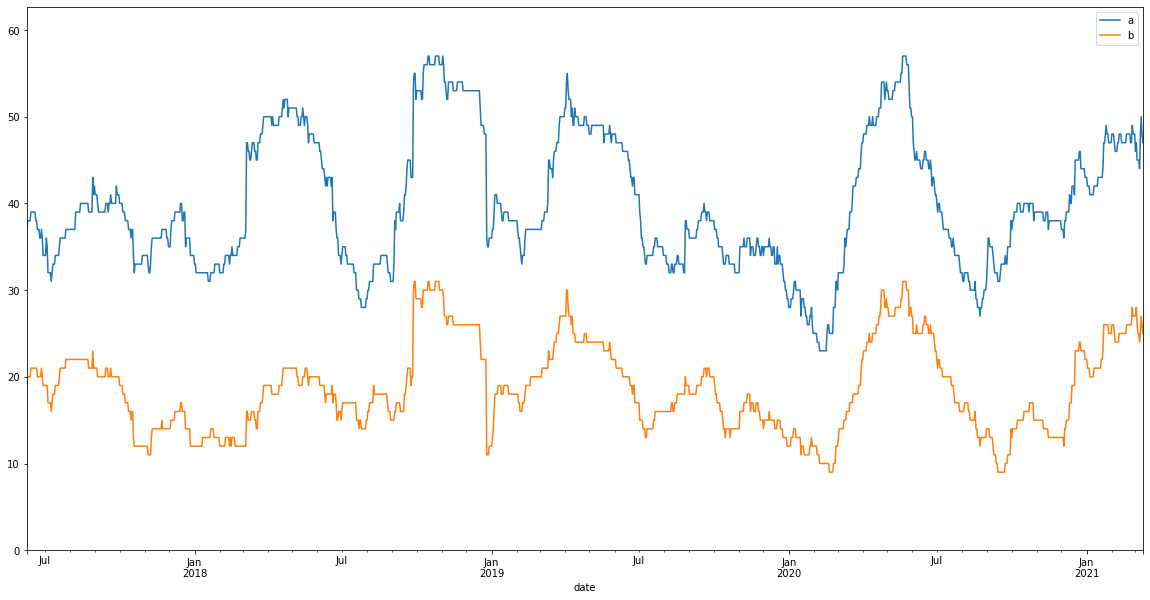

## Data a

Current: 47

One year before: 36

Day of maximum: 2018-10-15 00:00:00

## Data b

Current: 25

One year before: 16

Day of maximum: 2018-09-28 00:00:00

,a,b
count,1372.000000,1372.000000
mean,40.005102,18.698251
std,7.654986,5.081185
min,23.000000,9.000000
25%,34.000000,15.000000
50%,38.000000,18.000000
75%,47.000000,22.000000
max,57.000000,31.000000


In [238]:
display(Markdown("# with_team hat kaum einen Einfluss auf den Verlauf -> nicht alle Teammitglieder sind dabei + ohne Team <= Hälfte ca"))
show_author_count_plot(compare=True, with_team_b=False)

# Anzahl Langzeit-Autor:innen zeitlich stabil

### Plot

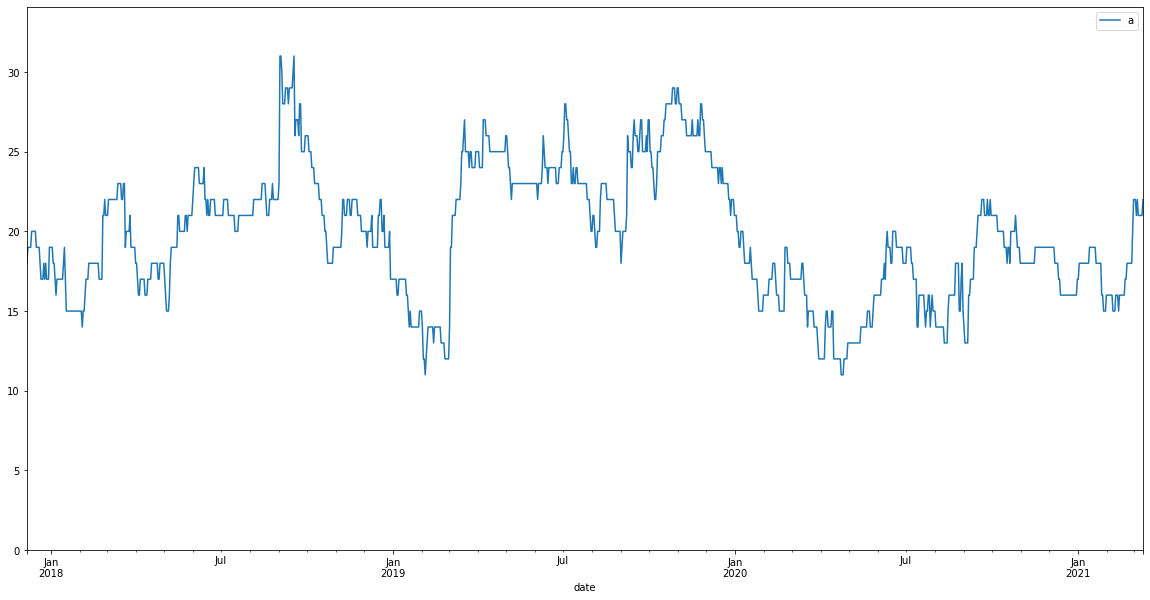

## Data a

Current: 22.0

One year before: 18.0

Day of maximum: 2018-09-02 00:00:00

,a
count,1192.000000
mean,19.760067
std,4.047512
min,11.000000
25%,17.000000
50%,19.000000
75%,23.000000
max,31.000000


In [243]:
display(Markdown("# Anzahl Langzeit-Autor:innen zeitlich stabil"))
show_author_count_plot(long_time=True)

# Langzeit im Vergleich: Kaum Ausrutscher (Besser als with_team=False)

### Plot

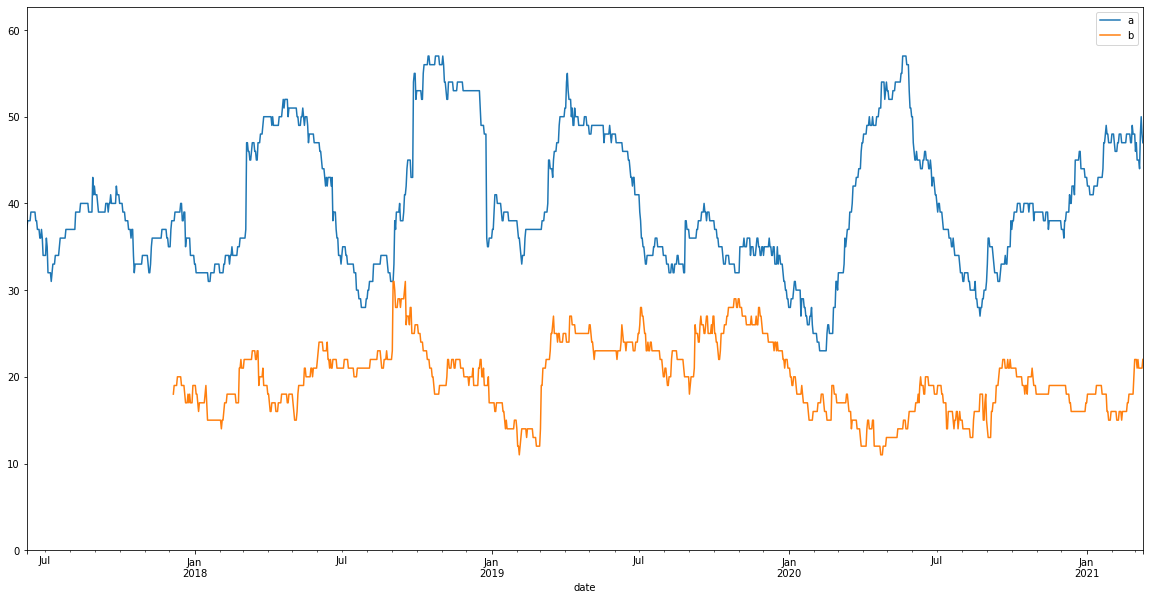

## Data a

Current: 47

One year before: 36

Day of maximum: 2018-10-15 00:00:00

## Data b

Current: 22.0

One year before: 18.0

Day of maximum: 2018-09-02 00:00:00

,a,b
count,1372.000000,1192.000000
mean,40.005102,19.760067
std,7.654986,4.047512
min,23.000000,11.000000
25%,34.000000,17.000000
50%,38.000000,19.000000
75%,47.000000,23.000000
max,57.000000,31.000000


In [240]:
show_author_count_plot(compare=True, long_time_b=True)

# Kein wesentlicher Unterschied zwischen "Inhalt" und "Inhalt+Taxonomy"

### Plot

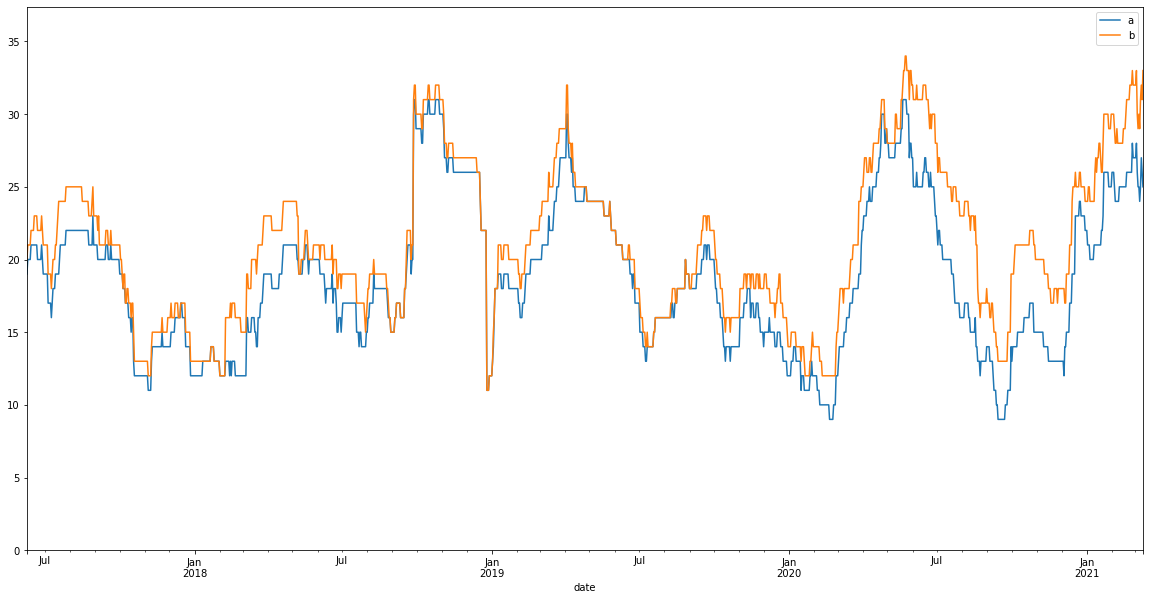

## Data a

Current: 25

One year before: 16

Day of maximum: 2018-09-28 00:00:00

## Data b

Current: 33

One year before: 18

Day of maximum: 2020-05-23 00:00:00

,a,b
count,1372.000000,1372.000000
mean,18.698251,21.002915
std,5.081185,5.281430
min,9.000000,11.000000
25%,15.000000,17.000000
50%,18.000000,21.000000
75%,22.000000,24.000000
max,31.000000,34.000000


In [245]:
show_author_count_plot(compare=True, with_team=False, with_team_b=False, event_type_b="Inhalt + Taxonomy")

# Anzahl sehr aktiver Autor:innen konstant

### Plot

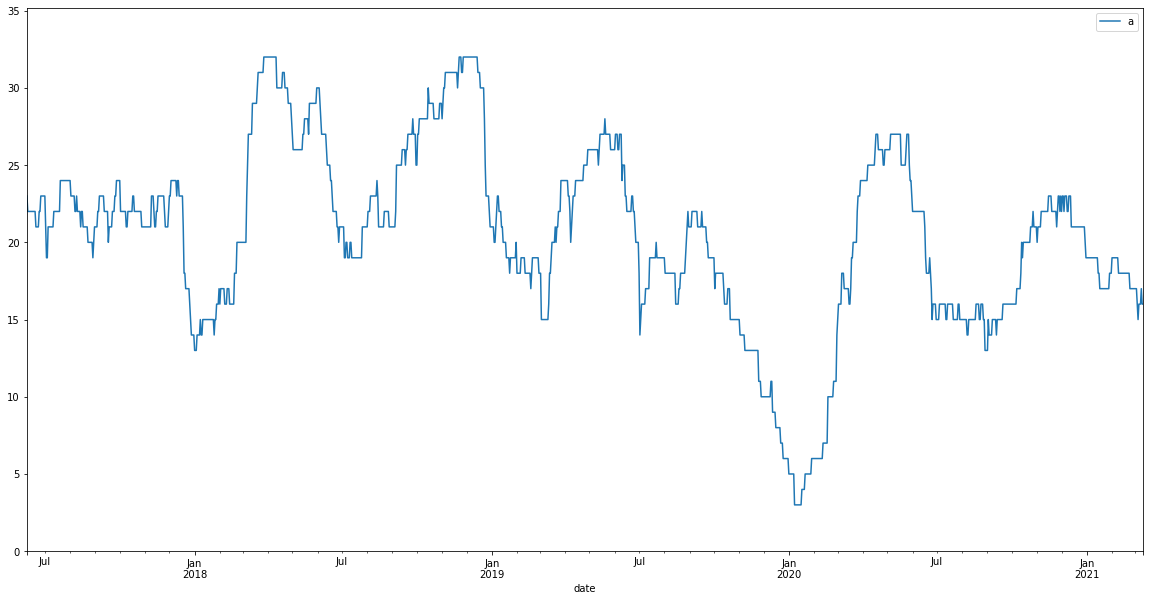

## Data a

Current: 16

One year before: 17

Day of maximum: 2018-03-27 00:00:00

,a
count,1372.000000
mean,20.477405
std,5.887859
min,3.000000
25%,17.000000
50%,21.000000
75%,24.000000
max,32.000000


In [248]:
show_author_count_plot(lower=50)

### Plot

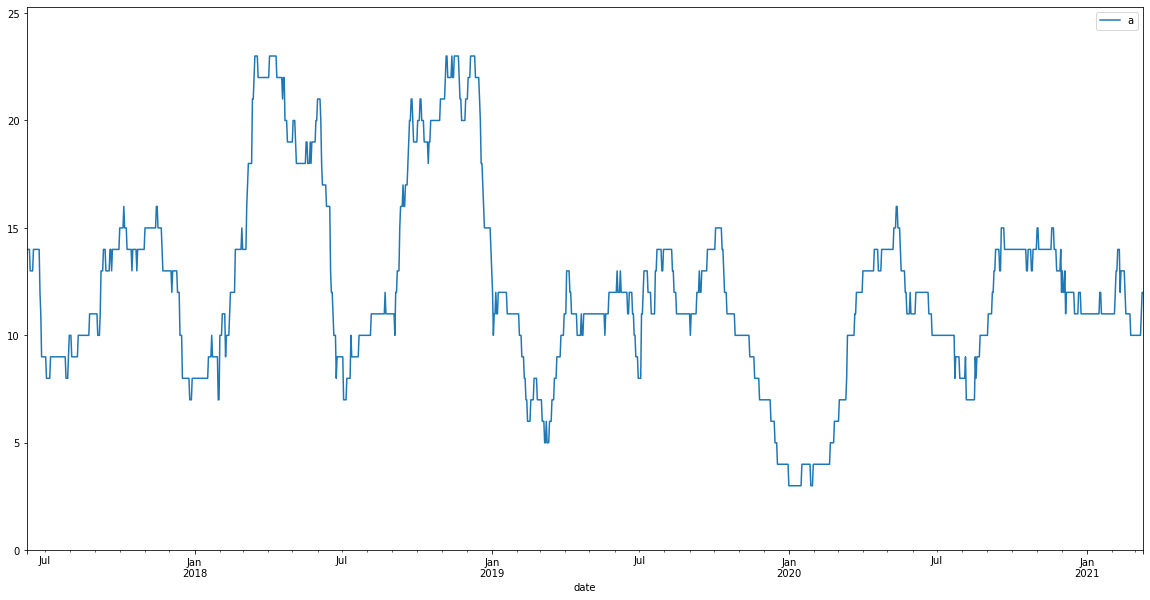

## Data a

Current: 12

One year before: 8

Day of maximum: 2018-03-16 00:00:00

,a
count,1372.000000
mean,12.145044
std,4.357153
min,3.000000
25%,10.000000
50%,11.000000
75%,14.000000
max,23.000000


In [249]:
show_author_count_plot(lower=100)

# Anzahl sehr aktive Langzeit-Autor:innen hat sich im letzten Jahr verbessert, aber auf Niveau wie vor 3 Jahre

### Plot

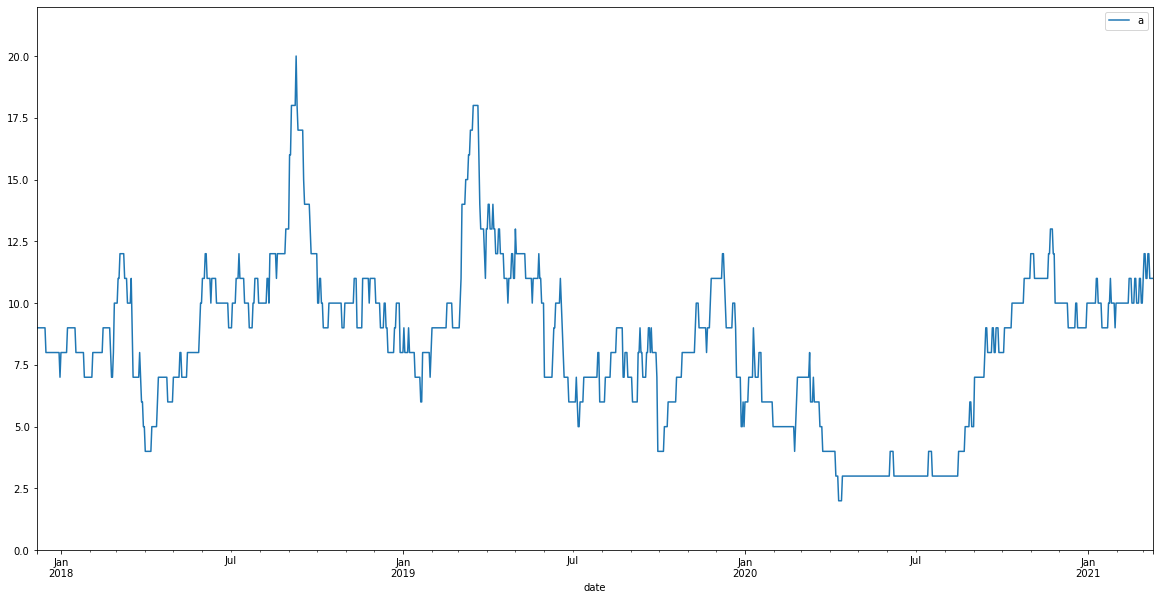

## Data a

Current: 11.0

One year before: 6.0

Day of maximum: 2018-09-09 00:00:00

,a
count,1192.000000
mean,8.346477
std,3.086482
min,2.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,20.000000


In [251]:
show_author_count_plot(lower=50, long_time=True)

# Anteil vom Team in der Community der sehr aktiven Langzeit-Autor:innen ist sehr hoch (~ 75%)

### Plot

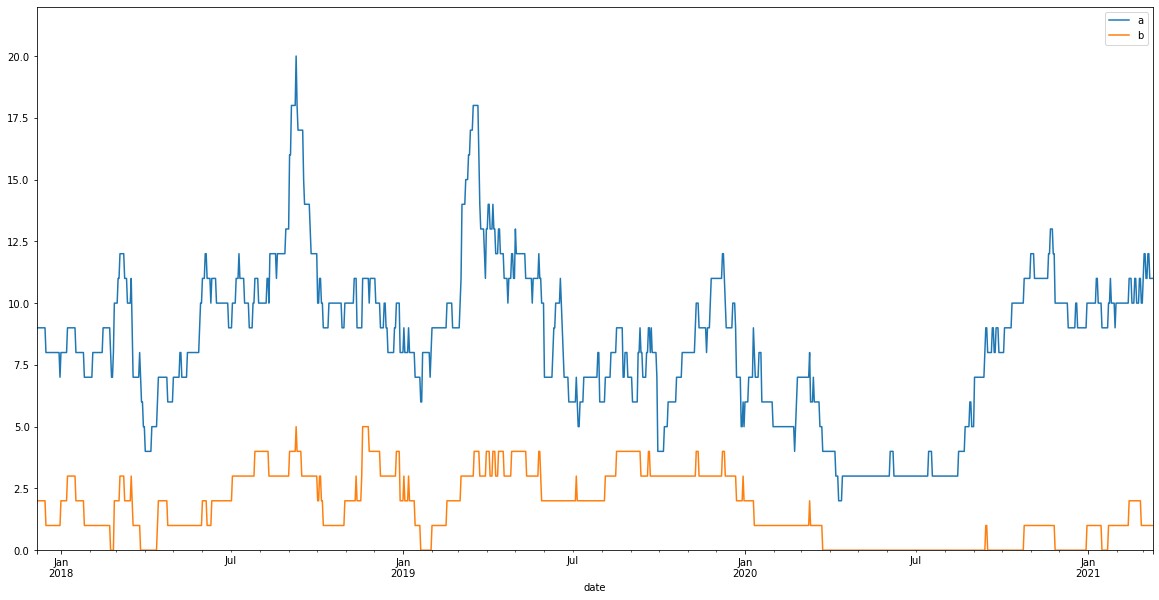

## Data a

Current: 11.0

One year before: 6.0

Day of maximum: 2018-09-09 00:00:00

## Data b

Current: 1.0

One year before: 1.0

Day of maximum: 2018-09-09 00:00:00

,a,b
count,1192.000000,1192.000000
mean,8.346477,1.694631
std,3.086482,1.335697
min,2.000000,0.000000
25%,7.000000,1.000000
50%,9.000000,2.000000
75%,10.000000,3.000000
max,20.000000,5.000000


In [254]:
show_author_count_plot(lower=50, long_time=True, compare=True, long_time_b=True, with_team_b=False, lower_b=50)

# Anzahl Reviewer:innen steigt

### Plot

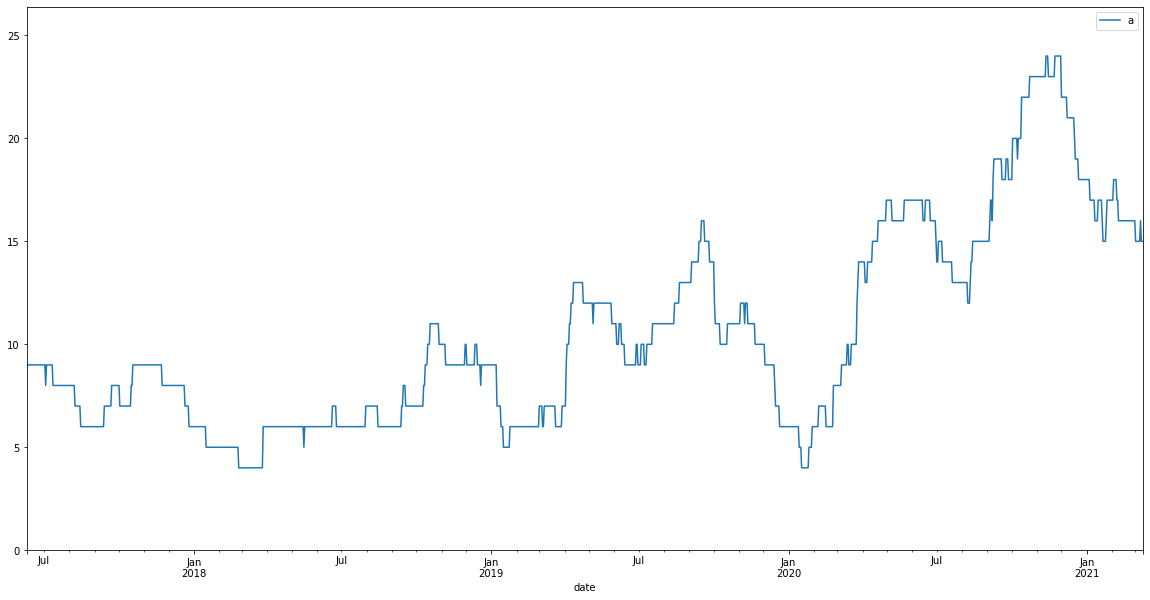

## Data a

Current: 15

One year before: 9

Day of maximum: 2020-11-12 00:00:00

,a
count,1371.000000
mean,10.426696
std,4.823708
min,4.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,24.000000


In [256]:
show_author_count_plot(event_type="Reviewing")

# Anzahl aktiver Reviewer:innen steigt (>= 50 Reviews)

### Plot

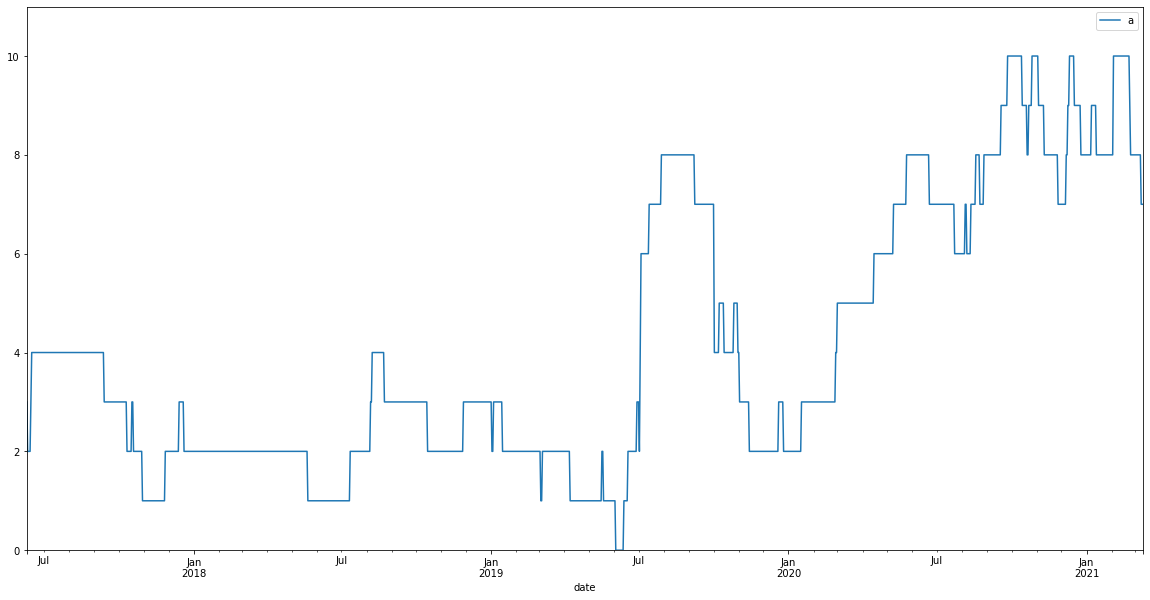

## Data a

Current: 7

One year before: 5

Day of maximum: 2020-09-26 00:00:00

,a
count,1371.000000
mean,4.129103
std,2.710637
min,0.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,10.000000


In [258]:
show_author_count_plot(event_type="Reviewing", lower=50)

# Anzahl an Langzeit Reviewer:innen steigt

### Plot

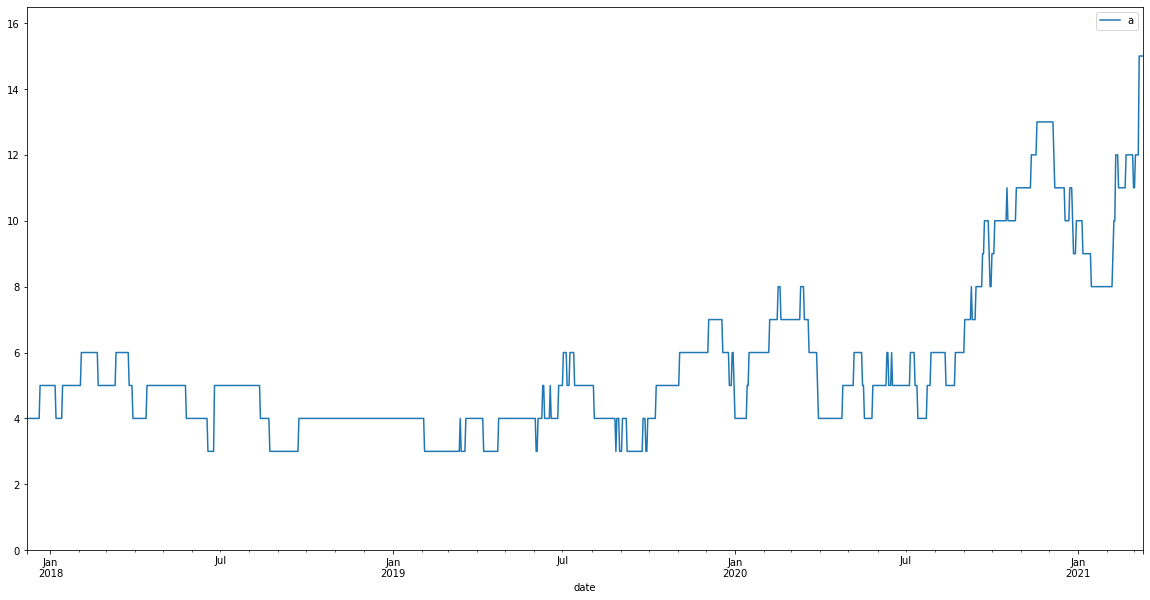

## Data a

Current: 15.0

One year before: 8.0

Day of maximum: 2021-03-07 00:00:00

,a
count,1191.000000
mean,5.545760
std,2.396646
min,3.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,15.000000


In [259]:
show_author_count_plot(event_type="Reviewing", long_time=True)

# Anteil an Teammitgliedern im Reviewing ist sehr hoch

### Plot

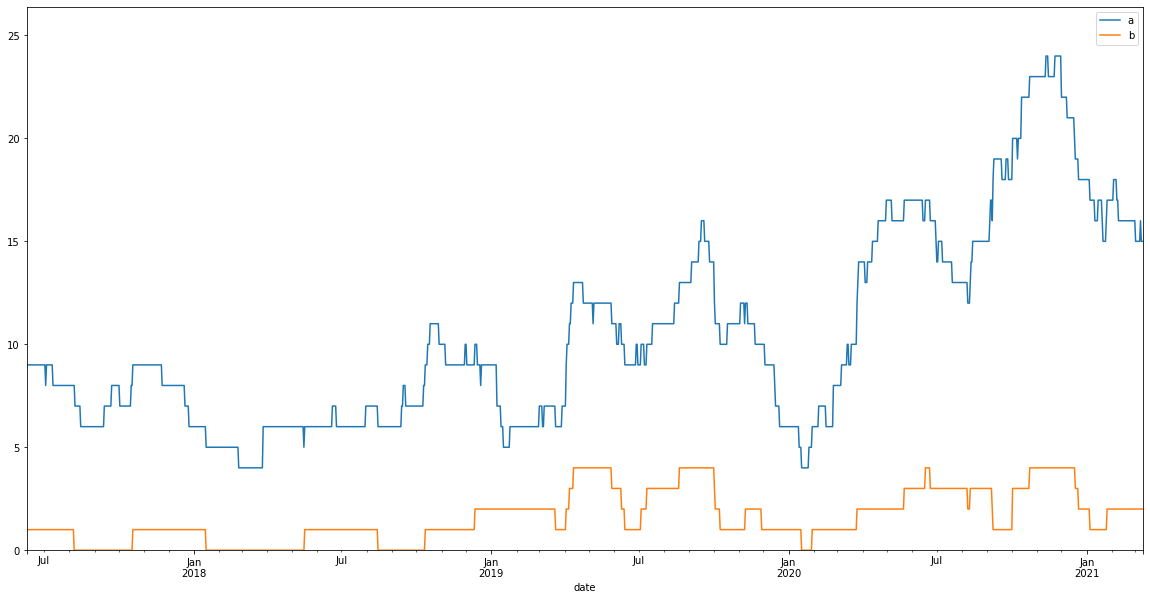

## Data a

Current: 15

One year before: 9

Day of maximum: 2020-11-12 00:00:00

## Data b

Current: 2

One year before: 1

Day of maximum: 2019-04-12 00:00:00

,a,b
count,1371.000000,1371.000000
mean,10.426696,1.595915
std,4.823708,1.248104
min,4.000000,0.000000
25%,6.000000,1.000000
50%,9.000000,1.000000
75%,14.000000,2.000000
max,24.000000,4.000000


In [261]:
show_author_count_plot(event_type="Reviewing", compare=True, with_team_b=False)

### Plot

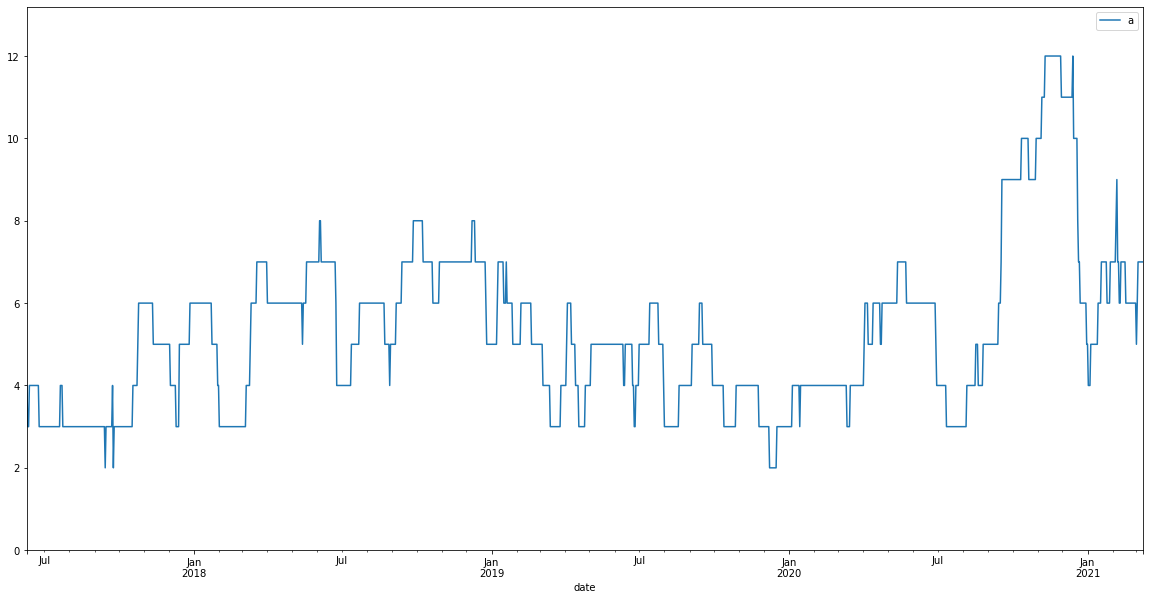

## Data a

Current: 7

One year before: 4

Day of maximum: 2020-11-10 00:00:00

,a
count,1370.000000
mean,5.272993
std,1.959022
min,2.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,12.000000


In [262]:
show_author_count_plot(event_type="Administration")